 Example.jl









 Paul.Soderlind@unisg.ch, April 2002, to Julia Nov 2015

In [1]:
using Dates, Optim

include("jlFiles/BondPricePs.jl")
include("jlFiles/BondNSxPs.jl")
include("jlFiles/printmat.jl")


ytmLoss  = 0           #0: mimimize squared price errors: 1: minimize squared ytm errors
  weightLoss = 1       #1: 1/mat as weights for (fitted price-price)^2 in loss fn (only if ytmLoss==0)

1

In [2]:
                                 #Swedish bond data for 29 Dec 1993

#coupons in %/yr
c  = [ 0;        0;         0;         0;         11.5;      10.75;
       11;       13;        10.25;     6;         9 ]

#time to maturity in year
tm = [ 0.00274;  0.21096;   0.46027;   0.88219;   1.67397;   3.06849;
       5.06301;  7.46027;   9.34795;   11.11507;  15.30685 ]

#interest rates.  Bills: simple rates in %/yr; bonds: yield to maturity in %/yr
y  = [ 7.75;     6.835;    6.655;     6.41;      6.215;     6.195;
       6.41;     6.755;    7.01;      7.21;      7.325 ]

n = length(y)       #number of bonds

Base.require_one_based_indexing(tm,y)

true

In [3]:
#transform the data

c  = c/100 # -> column vector, coupons and yields as 0.05 rather than 5
y  = y/100

vvc    = c .== 0                #if bill, change from simple to effective rate
y[vvc] = (1 .+ tm[vvc].*y[vvc]).^(1.0./tm[vvc]) .- 1

P = fill(NaN,length(y))         #calculate bond prices
for i = 1:n
  local ti
  ti   = mod(tm[i],1):tm[i]
  P[i] = BondPricePs(y[i],c[i],ti)
end

In [4]:
#estimating parameters in extended Nelson&Siegel model, restricted so b0 + b1 = log(1+y[1])

parX0 = [0.1045;-0.03;-0.0562;1.2;0;0.5]       #starting guess

if ytmLoss == 1                                #loss(ytm)
  NSXbR = BondNSxEstPs(parX0,y,tm,c,log(1+y[1]),1)
else
  if weightLoss == 1                           #loss(P/maturity)
    NSXbR = BondNSxEstPs(parX0,P,tm,c,log(1+y[1]),0,1.0./tm)
  else                                         #loss(P)
    NSXbR = BondNSxEstPs(parX0,P,tm,c,log(1+y[1]))
  end
end

println("\nParameter estimates: ")
printTable(NSXbR,[""],["b0","b1","b2","tau","b3","tau2"])


Parameter estimates: 
              
b0       0.081
b1      -0.003
b2      -0.062
tau      1.634
b3      -0.020
tau2     0.175



In [5]:
ytmx = fill(NaN,n)            #model implied ytm
for i = 1:n
  local ti,d,Qx
  ti      = mod(tm[i],1):tm[i]
  d       = BondNSxPs(ti,NSXbR...)[3]    #... expands into NSXbR[1],NSXbR[2],...
  Qx      = sum(d.*c[i]) + d[end]     #model implied bond price
  #println(ti)
  ytmx[i] = BondYieldToMatPs(Qx,c[i],ti,1,1,0.05,1e-7)[1]
end

println("\nActual and model ytm, %: ")
printTable([y ytmx]*100,["ytm actual","ytm model"],string.(tm),width=15,cell00="maturity")


Actual and model ytm, %: 
maturity     ytm actual      ytm model
0.00274           8.057          8.035
0.21096           7.022          7.073
0.46027           6.775          6.718
0.88219           6.434          6.468
1.67397           6.215          6.216
3.06849           6.195          6.167
5.06301           6.410          6.439
7.46027           6.755          6.765
9.34795           7.010          6.985
11.11507          7.210          7.187
15.30685          7.325          7.346



In [6]:
#calculate model implied rates (spot, forward, yield to maturity) to plot

tmFig      = [1e-8;0.1:0.1:16]           #maturities to plot
(shx,fhx,) = BondNSxPs(tmFig,NSXbR...)
shx        = exp.(shx) .- 1     #effective interest rate
fhx        = exp.(fhx) .- 1

println("\nmodel spot and forward rates, %: ")
printTable([shx fhx]*100,["spot","forward"],string.(tmFig),width=15,cell00="maturity")


model spot and forward rates, %: 
maturity           spot        forward
1.0e-8            8.057          8.057
0.1               7.443          6.994
0.2               7.100          6.590
0.3               6.900          6.437
0.4               6.774          6.363
0.5               6.686          6.306
0.6               6.618          6.245
0.7               6.560          6.178
0.8               6.508          6.110
0.9               6.460          6.045
1.0               6.415          5.987
1.1               6.374          5.938
1.2               6.336          5.900
1.3               6.301          5.871
1.4               6.270          5.854
1.5               6.241          5.846
1.6               6.217          5.848
1.7               6.195          5.858
1.8               6.177          5.875
1.9               6.162          5.899
2.0               6.149          5.929
2.1               6.139          5.964
2.2               6.132          6.003
2.3               6.128      

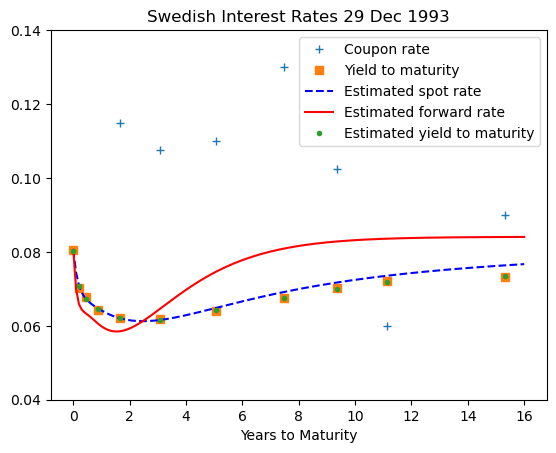

(0.04, 0.14)

In [7]:
#Comment out this if you do not have PyPlot installed.

using PyPlot
PyPlot.svg(false)           #prettier figures if `true`
close("all")
                                       #plotting
figure()
  plot(tm,c,"+",tm,y,"s",tmFig,shx,"b--",tmFig,fhx,"r-",tm,ytmx,".")
  title("Swedish Interest Rates 29 Dec 1993")
  xlabel("Years to Maturity")
  legend(["Coupon rate","Yield to maturity","Estimated spot rate",
         "Estimated forward rate","Estimated yield to maturity"],loc=1)
  ylim(0.04,0.14)
  #display(gcf())            #uncomment in VsCode

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*